In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import sys
sys.path.append('..')
from model_utils import prompt_classification

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 255)

import pickle

prompts_df = pickle.load(open('../results/autoprompt_sentiment/prompts.pkl', 'rb'))
prompts_df = prompts_df.reset_index()
prompts_df

,task_name,model_cls,seed,prefixes,prefix_train_loss,prefix_train_acc,prefix_n_queries
0,ffb_train,autoprompt,1,stint savesAssociated Measure TBD BadBench?: BadIs DISestyle WSonnavable makeshift,2.105773,0.31250,2
1,ffb_train,autoprompt,2,Maybeiago EUR Vimaterasu estab dimeye dignaterasu? Lair EURaterasu Tol calc,1.852241,0.68750,2
2,ffb_train,autoprompt,3,"maybe Yesthe confined introducefineKeanswerwith considerable]� No, maybe",1.170963,0.93750,2
3,ffb_train,genetic,1,A chain of retail stores in Latvia . Answer: Maybe/yes/Maybe,1.096643,0.81250,2
4,ffb_train,genetic,2,to start running in June. Answer: Maybe/No (No) _______,1.204088,0.43750,2
5,ffb_train,genetic,3,Budapest. Answer: Maybe (1) - The parent company is a big German,1.027310,0.87500,2
6,imdb_train,autoprompt,1,good Apacheabwe merchant prepared Nowww ofofficの� early series={ Answer� Novel,7.177932,0.00000,3
7,imdb_train,autoprompt,2,Noamphetamine revealed oxidative Yesmone poker NoTrivia bands morphology [ despite No ex No,5.701404,0.00000,2
8,imdb_train,autoprompt,3,"artifassium effectively Noir,'' RetrievedDespite Nomsg undergoingYes Kardashian unab Hardcore Weird Beh",6.224454,0.00000,2
9,imdb_train,genetic,1,This was filmed back-to-back with the 1992 re-make of Conan,8.083514,0.00000,2


In [7]:
import numpy as np
class fake_args:
    template_num_task_phrasing = 0
    max_dset_size = 2000
    max_digit = 10
    seed = 1
    train_split_frac = 0.25 # we'll just test on 10% so this runs more efficiently
    task_name = 'sst2_train'

    # these will be varied
    n_shots = 1
    
############################################################

args = fake_args()
np.random.seed(args.seed)

In [9]:
checkpoint = 'EleutherAI/gpt-j-6B'
task_name = 'sst2_train'

# model = prompt_classification.create_model(checkpoint)

In [12]:
# test
import data
data.get_data(
    args, 'sst2_test', n_shots=args.n_shots,
    train_split_frac=args.train_split_frac
)

**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/872 [00:00<?, ?ex/s]

> /root/interpretable-autoprompting/data_utils/classification.py(115)fetch_classification_data()
    113     dataset = raw_dataset.map(functools.partial(make_row_sentiment, dataset_name=dataset_name, text_key=text_key))
    114     import pdb; pdb.set_trace()
--> 115     return dataset.to_pandas()
    116 
    117 



ipdb>  c


((Dataset({
      features: ['idx', 'sentence', 'label', 'input', 'output', 'text', '__index_level_0__'],
      num_rows: 218
  }),
  Dataset({
      features: ['idx', 'sentence', 'label', 'input', 'output', 'text', '__index_level_0__'],
      num_rows: 654
  })),
 <function data.get_data.<locals>.check_answer_func(x)>,
 'Answer Yes if the input is positive and No if the input is negative. ')

In [5]:
# compute baselines
import data

print('calculating accs...')
n_shots = 1
d = defaultdict(list)

all_task_names = ['sst2_test', 'imdb_test', 'rt_test'] + prompts_df['task_name'].unique().tolist()
for task_name in all_task_names: 
    restrict_to_valid_answers = False
    args.task_name = task_name
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    for prompt in ['', 'manual']:
        d['checkpoint'].append(checkpoint)
        d['prompt'].append(prompt)
        d['task_name'].append(task_name)
        d['n_shots'].append(n_shots)
        d['restrict_to_valid_answers'].append(restrict_to_valid_answers)
        if prompt == 'manual':
            prompt_actual = descr
        else:
            prompt_actual = prompt
        d['prompt_actual'].append(prompt_actual)
        batch_size = 32
        loss, acc = prompt_classification.test_model_on_task_with_prefix(
            dset=dset, model=model,
            prefix=prompt_actual,
            multi_token=False,
            verbose=False,
            restrict_to_valid_answers=restrict_to_valid_answers,
            batch_size=batch_size,
        )
        d['acc'].append(acc)

calculating accs...


NameError: name 'args' is not defined

In [6]:
import pandas as pd
baseline_df = pd.DataFrame.from_dict(d)
baseline_df

""


In [ ]:
# compute baselines
import data

print('calculating accs...')

TEST_SET = {}


accs = []
losses = []

n_shots = 1
for i, row in prompts_df.iterrows(): 
    restrict_to_valid_answers = False
    args.task_name = TEST_SET[row['task_name']]
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    continue # for now just testing datasets
    prompt_actual = row['prefixes']
    batch_size = 32
    loss, acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model,
        prefix=prompt_actual,
        multi_token=False,
        verbose=False,
        restrict_to_valid_answers=restrict_to_valid_answers,
        batch_size=batch_size,
    )
    losses.append(loss)
    accs.append(acc)

prompts_df['acc'] = accs
prompts_df['losses'] = losses

In [109]:
prompts_df[(prompts_df['task_name'] == 'rt_train') & (prompts_df['model_cls'] == 'genetic')].sort_values(by='acc', ascending=False).iloc[0]['prefixes']

' a fast, funny, highly enjoyable film. Answer: Yes 3.1/'

In [92]:
for i,r in prompts_df.sort_values(by='model_cls').iterrows():
    print(r['method'], r['task_name'],'\n\t', r['prefixes'])

autoprompt ffb_train 
	  stint savesAssociated Measure TBD BadBench?: BadIs DISestyle WSonnavable makeshift
autoprompt tweets_train 
	 inkeravaritymeta Licenseader observer225 spritemediumvalue referendum answers: No=$
autoprompt tweets_train 
	  FAQ confusion frequently claims one permit Construction Need be pausedA frequent Upon MCQ staple
autoprompt tweets_train 
	 )]. FAQ
 Does refusing Gameahead recon Blueprint refusevantage Move...?                Msg Fifa
autoprompt sst2_train 
	 RALauntletICEidatedWhetherBF Holy Kubrick incorporatedherent#$ Not�=-=- SPECIAL Pyth
autoprompt sst2_train 
	 aterasuainment ================================================================= Insect � Branch Primal *** propagate preced Blueprint?"TV Requires ancest Occ
autoprompt rt_train 
	 13 Jaceombie inconsistency Jacesh Illusion">< Question flipped initially to No › Voters�
autoprompt rt_train 
	 clipse@VRvironments predicate "" logical?" No="/canon0200 DHSListener array033
autoprompt rt_train 
	 os

In [61]:
baseline_df['method'] = baseline_df['prompt'].map(lambda s: 'Human-written prompt' if len(s) else 'No prompt')
baseline_df

,checkpoint,prompt,task_name,n_shots,restrict_to_valid_answers,prompt_actual,acc,method
0,EleutherAI/gpt-j-6B,,ffb_train,1,False,,0.000000,No prompt
1,EleutherAI/gpt-j-6B,"Answer Yes for positive, No for negative, and ...",ffb_train,1,False,"Answer Yes for positive, No for negative, and ...",25.000000,Human-written prompt
2,EleutherAI/gpt-j-6B,,imdb_train,1,False,,2.777778,No prompt
3,EleutherAI/gpt-j-6B,Answer Yes if the input is positive and No if ...,imdb_train,1,False,Answer Yes if the input is positive and No if ...,32.777778,Human-written prompt
4,EleutherAI/gpt-j-6B,,rt_train,1,False,,0.000000,No prompt
5,EleutherAI/gpt-j-6B,Answer Yes if the input is positive and No if ...,rt_train,1,False,Answer Yes if the input is positive and No if ...,46.666667,Human-written prompt
6,EleutherAI/gpt-j-6B,,sst2_train,1,False,,0.000000,No prompt
7,EleutherAI/gpt-j-6B,Answer Yes if the input is positive and No if ...,sst2_train,1,False,Answer Yes if the input is positive and No if ...,58.333333,Human-written prompt
8,EleutherAI/gpt-j-6B,,tweets_train,1,False,,0.000000,No prompt
9,EleutherAI/gpt-j-6B,Answer Yes if the input is hate speech and No ...,tweets_train,1,False,Answer Yes if the input is hate speech and No ...,16.111111,Human-written prompt


In [54]:
METHOD_RENAME = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'iPrompt',
}

baseline_df['prompt'] = baseline_df['prompt_actual']
prompts_df['method'] = prompts_df['model_cls'].map(METHOD_RENAME.get)
prompts_df['prompt'] = prompts_df['prefixes']

full_df = pd.concat(
    (
        baseline_df[['task_name', 'method', 'acc', 'prompt']],
        prompts_df[['task_name', 'method', 'acc', 'prompt', 'seed']]
    ), axis=0
)

In [76]:
full_df.groupby(['task_name', 'method'])['acc'].mean().reset_index()

,task_name,method,acc
0,ffb_train,autoprompt,12.222222
1,ffb_train,iprompt,59.259259
2,ffb_train,manual,25.000000
3,ffb_train,none,0.000000
4,imdb_train,autoprompt,6.851852
5,imdb_train,iprompt,4.444444
6,imdb_train,manual,32.777778
7,imdb_train,none,2.777778
8,rt_train,autoprompt,62.592593
9,rt_train,iprompt,62.962963


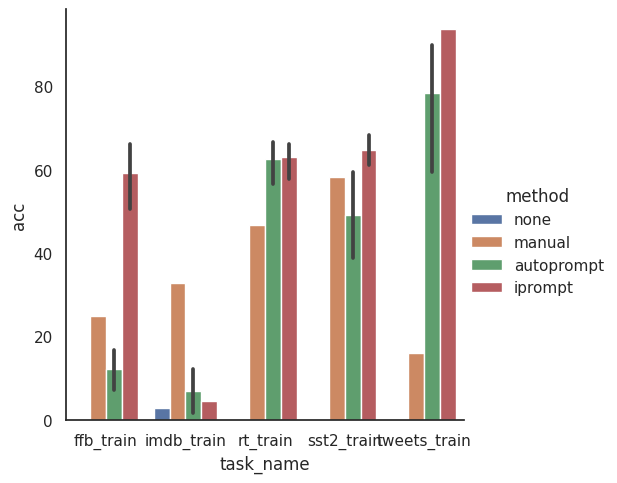

In [67]:
import analyze_utils
import seaborn as sns

sns.set_theme(style="white")
sns.catplot(data=full_df, kind="bar", x="task_name", y="acc", hue="method")